This is my project code for my final project of the course computer vision which is Brain Tumor detection. In this project we will try to detect brain

In [1]:
!unzip Brain_tumor.zip -d Brain_tumor_binary

Streaming output truncated to the last 5000 lines.
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0713.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0714.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0715.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0716.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0717.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0718.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0719.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0720.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0721.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0722.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0723.jpg  
  inflating: Brain_tumor_binary/Brain_tumor/Training/No_Tumor/Tr-no_0724.jpg  
 

In [2]:
!ls -l /content/Brain_tumor_binary/Brain_tumor

total 8
drwxrwxrwx 4 root root 4096 Nov 18 05:46 Testing
drwxrwxrwx 4 root root 4096 Nov 18 05:45 Training


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
DATA_DIR = "/content/Brain_tumor_binary/Brain_tumor/Training"
TEST_DIR = "/content/Brain_tumor_binary/Brain_tumor/Testing"
VAL_SPLIT = 0.2
SEED = 42

# Data augmentation step
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

#  VAL only rescaling, NO augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# TEST separate folder, only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 4570 images belonging to 2 classes.
Found 1142 images belonging to 2 classes.
Found 1311 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

weight_decay = 5e-5

model = models.Sequential([

    # -------- Block 1
    layers.Conv2D(32, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay),
                  input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(32, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.15),

    # -------- Block 2
    layers.Conv2D(64, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(64, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    # -------- Block 3
    layers.Conv2D(128, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(128, (3,3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    # -------- Classifier
    layers.GlobalAveragePooling2D(),

    layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(weight_decay)
    ),
    layers.Dropout(0.35),

    layers.Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 37, 37, 128)    │             

 Total params: 296,673 (1.13 MB)

 Trainable params: 295,777 (1.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
from tensorflow.keras.optimizers import AdamW,Adam
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(
        learning_rate=2e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
        ),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
callbacks = [
    # Save best model
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.7,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='max',
        cooldown=2
    ),

    # Stop if no improvement
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.001
    )
]

In [9]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    class_weight=None
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8747 - auc: 0.8928 - loss: 0.3479 - precision: 0.8868 - recall: 0.9486
Epoch 1: val_accuracy improved from -inf to 0.72067, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 319ms/step - accuracy: 0.8750 - auc: 0.8932 - loss: 0.3474 - precision: 0.8870 - recall: 0.9487 - val_accuracy: 0.7207 - val_auc: 0.0791 - val_loss: 0.6824 - val_precision: 0.7207 - val_recall: 1.0000 - learning_rate: 2.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9444 - auc: 0.9773 - loss: 0.1899 - precision: 0.9637 - recall: 0.9602
Epoch 2: val_accuracy did not improve from 0.72067
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.9444 - auc: 0.9773 - loss: 0.1897 - precision: 0.9637 - recall: 0.9603 - val_accuracy: 0.1103 - val_auc: 0.0777 - val_loss: 1.6690 - val_precision: 0.0383 - val_recall: 0.0097 - learning_rate: 2.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accur

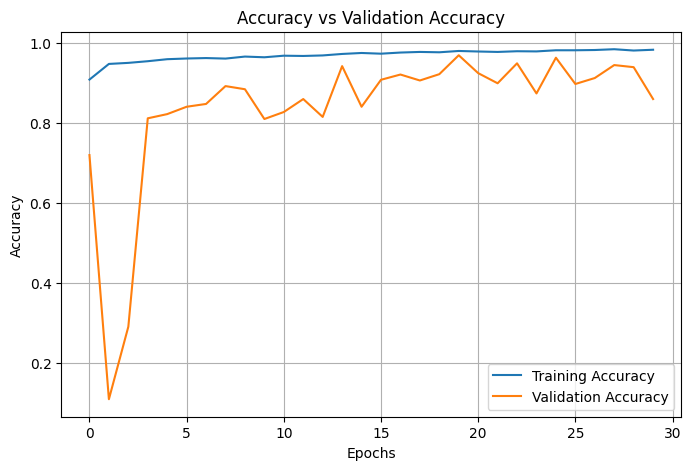

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

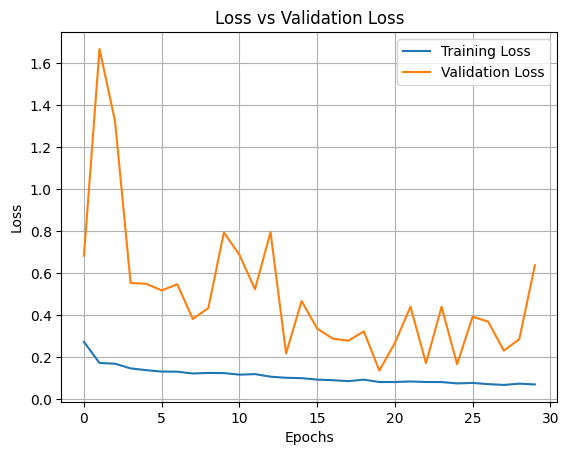

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

🔍 Checking class distribution...
Training samples: 4570
Training class distribution: 3294 positive, 1276 negative
Validation samples: 1142
Validation class distribution: 823 positive, 319 negative
Class weights: {0: np.float64(1.7907523510971788), 1: np.float64(0.693685488767456)}



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 37, 37, 128)    │             

 Total params: 305,441 (1.17 MB)

 Trainable params: 304,545 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

🚀 Starting training with stable configuration...
Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8041 - auc: 0.7716 - loss: 0.5669 - precision: 0.8675 - recall: 0.8643
Epoch 1: val_accuracy improved from -inf to 0.89142, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.8044 - auc: 0.7723 - loss: 0.5660 - precision: 0.8677 - recall: 0.8645 - val_accuracy: 0.8914 - val_auc: 0.9270 - val_loss: 0.3193 - val_precision: 0.8691 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9150 - auc: 0.9518 - loss: 0.2916 - precision: 0.9403 - recall: 0.9414
Epoch 2: val_accuracy did not improve from 0.89142
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.9150 - auc: 0.9518 - loss: 0.2915 - precision: 0.9403 - recall: 0.9414 - val_accuracy: 0.8879 - val_auc: 0.9553 - val_loss: 0.2908 - val_precision: 0.8662 - val_recall: 0.9988 - learning_rate: 0.0010
Epoch 3/60
143/143 ━

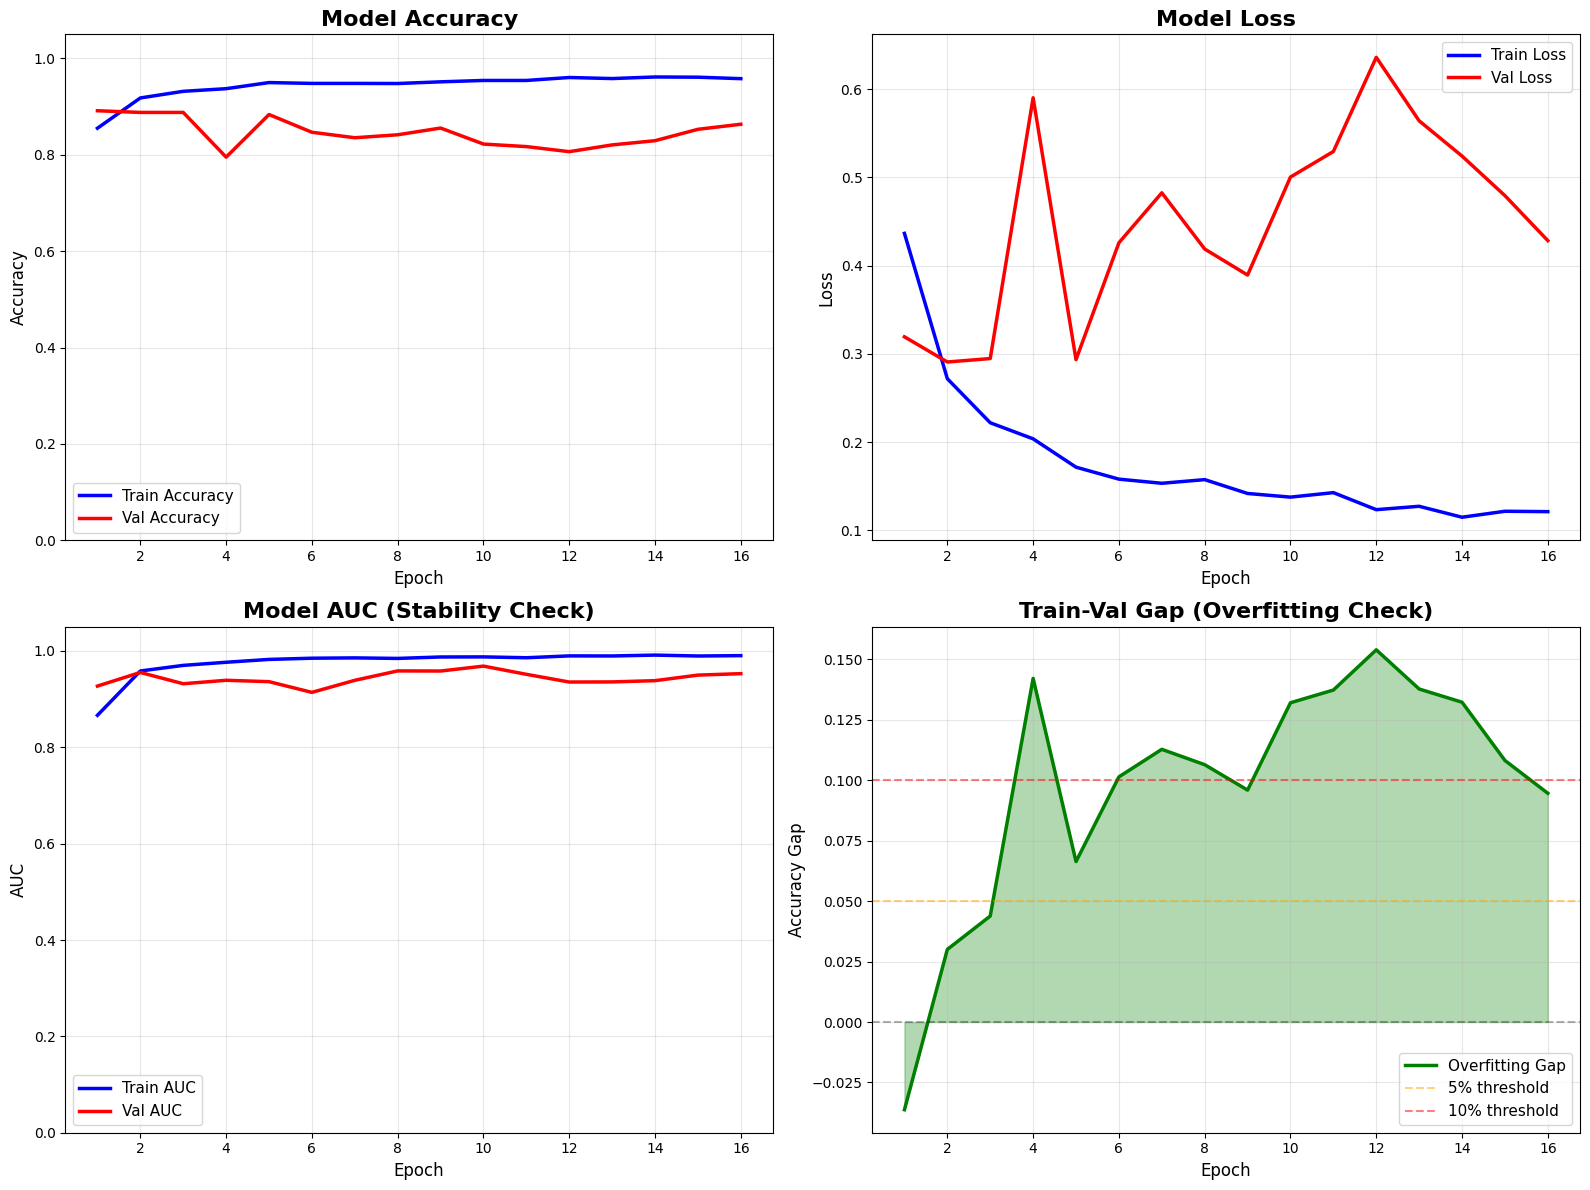


 Validation Accuracy Std Dev: 0.0296
 Very stable training!

🏆 BEST EPOCH SUMMARY
Best Epoch: 1
Training Accuracy:    0.8551
Validation Accuracy:  0.8914
Validation AUC:       0.9270
Validation Precision: 0.8691
Validation Recall:    1.0000
Overfitting Gap:      -0.0363

🧪 EVALUATING ON TEST SET...
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8084 - auc: 0.6630 - loss: 0.4676 - precision: 0.5469 - recall: 0.6701

📊 FINAL TEST SET RESULTS
Loss           : 0.3541
Compile_metrics: 0.8894

🎢 Maximum validation accuracy jump: 0.0928
✅ STABLE: Training converged smoothly!


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import numpy as np


# CHECKING CLASS DISTRIBUTION FIRST

print("🔍 Checking class distribution...")
print(f"Training samples: {train_generator.samples}")
print(f"Training class distribution: {train_generator.classes.sum()} positive, {len(train_generator.classes) - train_generator.classes.sum()} negative")
print(f"Validation samples: {val_generator.samples}")
print(f"Validation class distribution: {val_generator.classes.sum()} positive, {len(val_generator.classes) - val_generator.classes.sum()} negative")

# Calculating class weights if imbalanced
class_counts = np.bincount(train_generator.classes)
total = len(train_generator.classes)
class_weight = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}
print(f"Class weights: {class_weight}")
print()


# STABLE MODEL ARCHITECTURE

weight_decay = 1e-5

model = models.Sequential([
    # -------- Block 1 --------
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay),
                  input_shape=(150,150,3)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.1),

    # -------- Block 2
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    # -------- Block 3
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    # -------- Classifier
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])


# STABLE OPTIMIZER - SGD WITH MOMENTUM

model.compile(
    optimizer=SGD(
        learning_rate=0.001,
        momentum=0.9,
        nesterov=True
    ),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()


callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),


    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='max',
        cooldown=3
    ),

    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.005
    )
]


print("🚀 Starting training with stable configuration...")
print("="*60)

history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy
    axes[0, 0].plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2.5)
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2.5)
    axes[0, 0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1.05])


    val_acc = np.array(history.history['val_accuracy'])
    unstable = np.where(np.abs(np.diff(val_acc)) > 0.15)[0]
    for idx in unstable:
        axes[0, 0].axvspan(idx+1, idx+2, alpha=0.2, color='yellow')

    # Loss
    axes[0, 1].plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2.5)
    axes[0, 1].plot(epochs, history.history['val_loss'], 'r-', label='Val Loss', linewidth=2.5)
    axes[0, 1].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # AUC
    axes[1, 0].plot(epochs, history.history['auc'], 'b-', label='Train AUC', linewidth=2.5)
    axes[1, 0].plot(epochs, history.history['val_auc'], 'r-', label='Val AUC', linewidth=2.5)
    axes[1, 0].set_title('Model AUC (Stability Check)', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC', fontsize=12)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1.05])

    # Gap Analysis
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    gap = train_acc - val_acc

    axes[1, 1].plot(epochs, gap, 'g-', label='Overfitting Gap', linewidth=2.5)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='5% threshold')
    axes[1, 1].axhline(y=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
    axes[1, 1].fill_between(epochs, 0, gap, alpha=0.3, color='green')
    axes[1, 1].set_title('Train-Val Gap (Overfitting Check)', fontsize=16, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy Gap', fontsize=12)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_stable.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Stability metrics
    val_std = np.std(history.history['val_accuracy'])
    print(f"\n Validation Accuracy Std Dev: {val_std:.4f}")
    if val_std < 0.05:
        print(" Very stable training!")
    elif val_std < 0.10:
        print(" Moderate stability")
    else:
        print(" Unstable training - see recommendations below")

plot_training_history(history)


best_epoch = np.argmax(history.history['val_accuracy'])
print("\n" + "="*60)
print("🏆 BEST EPOCH SUMMARY")
print("="*60)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy:    {history.history['accuracy'][best_epoch]:.4f}")
print(f"Validation Accuracy:  {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Validation AUC:       {history.history['val_auc'][best_epoch]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][best_epoch]:.4f}")
print(f"Validation Recall:    {history.history['val_recall'][best_epoch]:.4f}")
print(f"Overfitting Gap:      {history.history['accuracy'][best_epoch] - history.history['val_accuracy'][best_epoch]:.4f}")
print("="*60)


print("\n🧪 EVALUATING ON TEST SET...")
test_results = model.evaluate(test_generator, verbose=1)
print("\n" + "="*60)
print("📊 FINAL TEST SET RESULTS")
print("="*60)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name.capitalize():15s}: {value:.4f}")
print("="*60)


val_acc_array = np.array(history.history['val_accuracy'])
jumps = np.abs(np.diff(val_acc_array))
max_jump = np.max(jumps)
print(f"\n🎢 Maximum validation accuracy jump: {max_jump:.4f}")
if max_jump > 0.15:
    print("⚠️  UNSTABLE: Large accuracy swings detected!")
    print("\n💡 RECOMMENDATIONS:")
    print("1. Further reduce learning rate to 0.0001")
    print("2. Increase batch size to 64 if memory allows")
    print("3. Check for corrupted images in validation set")
    print("4. Verify validation split is stratified")
else:
    print("✅ STABLE: Training converged smoothly!")

🔍 Checking class distribution...
Training samples: 4570
Training class distribution: 3294 positive, 1276 negative
Validation samples: 1142
Validation class distribution: 823 positive, 319 negative
Class weights: {0: np.float64(1.7907523510971788), 1: np.float64(0.693685488767456)}



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 37, 37, 128)    │             

 Total params: 305,441 (1.17 MB)

 Trainable params: 304,545 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

🚀 Starting training with stable configuration...
Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7597 - auc: 0.7886 - loss: 0.5276 - precision: 0.8604 - recall: 0.7946
Epoch 1: val_accuracy improved from -inf to 0.88441, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 266ms/step - accuracy: 0.7602 - auc: 0.7892 - loss: 0.5270 - precision: 0.8606 - recall: 0.7951 - val_accuracy: 0.8844 - val_auc: 0.8902 - val_loss: 0.3493 - val_precision: 0.8618 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9003 - auc: 0.9302 - loss: 0.3401 - precision: 0.9231 - recall: 0.9367
Epoch 2: val_accuracy did not improve from 0.88441
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.9004 - auc: 0.9304 - loss: 0.3398 - precision: 0.9232 - recall: 0.9368 - val_accuracy: 0.8398 - val_auc: 0.8757 - val_loss: 0.3909 - val_precision: 0.8272 - val_recall: 0.9830 - learning_rate: 5.0000e-04
Epoch 3/60
1

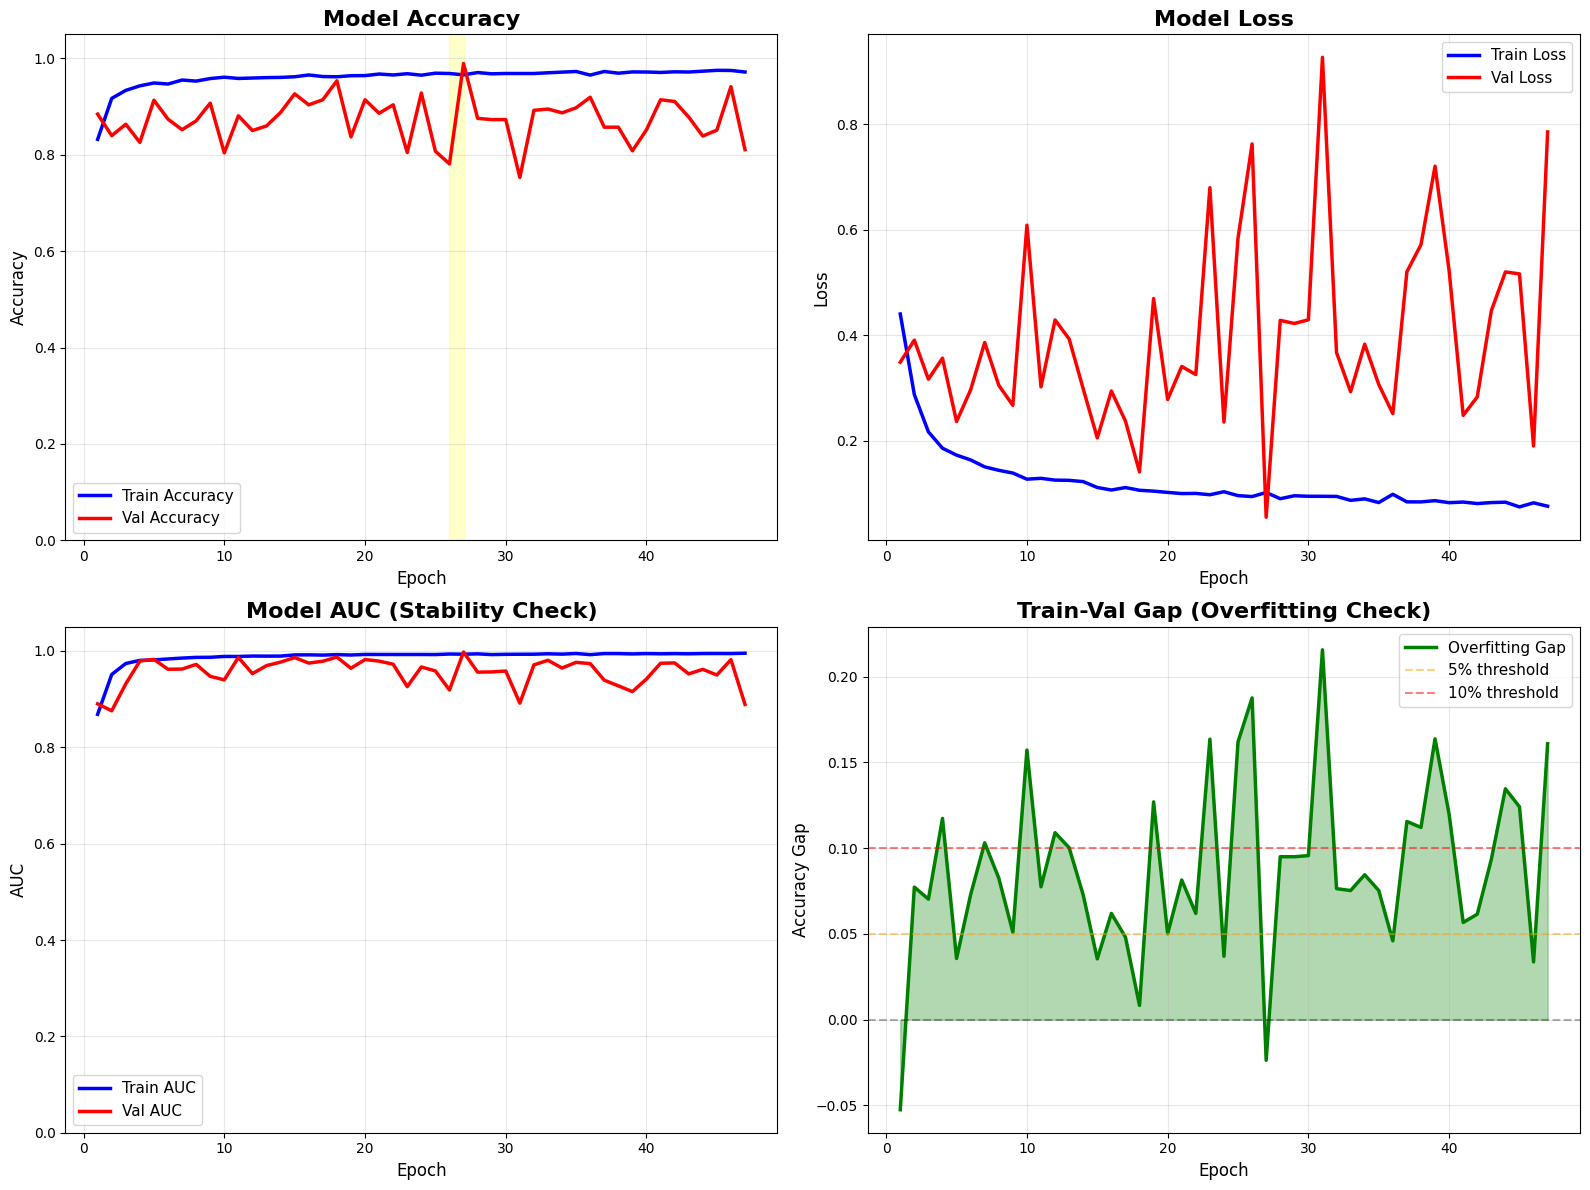


 Validation Accuracy Std Dev: 0.0460
 Very stable training!

 BEST EPOCH SUMMARY
Best Epoch: 27
Training Accuracy:    0.9659
Validation Accuracy:  0.9895
Validation AUC:       0.9977
Validation Precision: 0.9939
Validation Recall:    0.9915
Overfitting Gap:      -0.0236

 EVALUATING ON TEST SET...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9390 - auc: 0.6982 - loss: 0.2098 - precision: 0.7009 - recall: 0.6223

 FINAL TEST SET RESULTS
Loss           : 0.3299
Compile_metrics: 0.8818

 Maximum validation accuracy jump: 0.2084
  UNSTABLE: Large accuracy swings detected!

 RECOMMENDATIONS:
1. Further reduce learning rate to 0.0001
2. Increase batch size to 64 if memory allows
3. Check for corrupted images in validation set
4. Verify validation split is stratified


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import numpy as np


print("🔍 Checking class distribution...")
print(f"Training samples: {train_generator.samples}")
print(f"Training class distribution: {train_generator.classes.sum()} positive, {len(train_generator.classes) - train_generator.classes.sum()} negative")
print(f"Validation samples: {val_generator.samples}")
print(f"Validation class distribution: {val_generator.classes.sum()} positive, {len(val_generator.classes) - val_generator.classes.sum()} negative")

# Calculate class weights if imbalanced
class_counts = np.bincount(train_generator.classes)
total = len(train_generator.classes)
class_weight = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}
print(f"Class weights: {class_weight}")
print()


weight_decay = 1e-5

model = models.Sequential([
    # -------- Block 1 --------
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay),
                  input_shape=(150,150,3)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.1),

    # -------- Block 2
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    # -------- Block 3
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(momentum=0.9),
    layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    # -------- Classifier
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=SGD(
        learning_rate=0.0005,
        momentum=0.95,
        nesterov=True
    ),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()


callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),


    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        mode='min',
        cooldown=5
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='min',
        min_delta=0.01
    )
]


print("🚀 Starting training with stable configuration...")
print("="*60)

history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy
    axes[0, 0].plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2.5)
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2.5)
    axes[0, 0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1.05])

    # Highlight unstable regions
    val_acc = np.array(history.history['val_accuracy'])
    unstable = np.where(np.abs(np.diff(val_acc)) > 0.15)[0]
    for idx in unstable:
        axes[0, 0].axvspan(idx+1, idx+2, alpha=0.2, color='yellow')

    # Loss
    axes[0, 1].plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2.5)
    axes[0, 1].plot(epochs, history.history['val_loss'], 'r-', label='Val Loss', linewidth=2.5)
    axes[0, 1].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # AUC
    axes[1, 0].plot(epochs, history.history['auc'], 'b-', label='Train AUC', linewidth=2.5)
    axes[1, 0].plot(epochs, history.history['val_auc'], 'r-', label='Val AUC', linewidth=2.5)
    axes[1, 0].set_title('Model AUC (Stability Check)', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC', fontsize=12)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1.05])

    # Gap Analysis
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    gap = train_acc - val_acc

    axes[1, 1].plot(epochs, gap, 'g-', label='Overfitting Gap', linewidth=2.5)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='5% threshold')
    axes[1, 1].axhline(y=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
    axes[1, 1].fill_between(epochs, 0, gap, alpha=0.3, color='green')
    axes[1, 1].set_title('Train-Val Gap (Overfitting Check)', fontsize=16, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy Gap', fontsize=12)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_stable.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Stability metrics
    val_std = np.std(history.history['val_accuracy'])
    print(f"\n Validation Accuracy Std Dev: {val_std:.4f}")
    if val_std < 0.05:
        print(" Very stable training!")
    elif val_std < 0.10:
        print("  Moderate stability")
    else:
        print(" Unstable training - see recommendations below")

plot_training_history(history)


best_epoch = np.argmax(history.history['val_accuracy'])
print("\n" + "="*60)
print(" BEST EPOCH SUMMARY")
print("="*60)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy:    {history.history['accuracy'][best_epoch]:.4f}")
print(f"Validation Accuracy:  {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Validation AUC:       {history.history['val_auc'][best_epoch]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][best_epoch]:.4f}")
print(f"Validation Recall:    {history.history['val_recall'][best_epoch]:.4f}")
print(f"Overfitting Gap:      {history.history['accuracy'][best_epoch] - history.history['val_accuracy'][best_epoch]:.4f}")
print("="*60)

# Test set evaluation
print("\n EVALUATING ON TEST SET...")
test_results = model.evaluate(test_generator, verbose=1)
print("\n" + "="*60)
print(" FINAL TEST SET RESULTS")
print("="*60)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name.capitalize():15s}: {value:.4f}")
print("="*60)

# Stability analysis
val_acc_array = np.array(history.history['val_accuracy'])
jumps = np.abs(np.diff(val_acc_array))
max_jump = np.max(jumps)
print(f"\n Maximum validation accuracy jump: {max_jump:.4f}")
if max_jump > 0.15:
    print("  UNSTABLE: Large accuracy swings detected!")
    print("\n RECOMMENDATIONS:")
    print("1. Further reduce learning rate to 0.0001")
    print("2. Increase batch size to 64 if memory allows")
    print("3. Check for corrupted images in validation set")
    print("4. Verify validation split is stratified")
else:
    print(" STABLE: Training converged smoothly!")

In [15]:
# Test-Time Augmentation
def predict_with_tta(model, generator, n_augmentations=5):
    predictions = []

    for i in range(n_augmentations):
        generator.reset()
        preds = model.predict(generator, verbose=0)
        predictions.append(preds)

    # Average predictions
    return np.mean(predictions, axis=0)

# Using TTA for test set
tta_predictions = predict_with_tta(model, test_generator, n_augmentations=5)
tta_classes = (tta_predictions > 0.5).astype(int).flatten()

# Evaluating
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"TTA Accuracy: {accuracy_score(test_generator.classes, tta_classes):.4f}")
print(f"TTA AUC: {roc_auc_score(test_generator.classes, tta_predictions):.4f}")

TTA Accuracy: 0.8818
TTA AUC: 0.9744


TEST SET ANALYSIS:
Test samples: 1311
Test class distribution: 906 positive, 405 negative
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step

Confusion Matrix:
[[402   3]
 [152 754]]


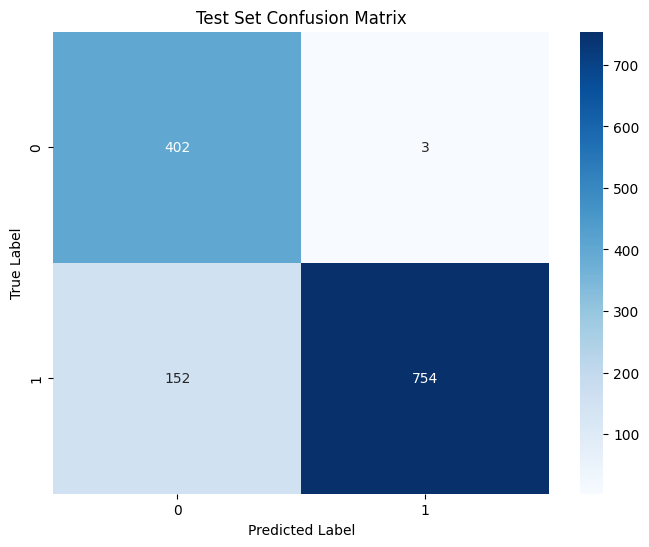


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.73      0.99      0.84       405
       Tumor       1.00      0.83      0.91       906

    accuracy                           0.88      1311
   macro avg       0.86      0.91      0.87      1311
weighted avg       0.91      0.88      0.89      1311



In [14]:
# Check test set distribution
print("TEST SET ANALYSIS:")
print(f"Test samples: {test_generator.samples}")
print(f"Test class distribution: {test_generator.classes.sum()} positive, {len(test_generator.classes) - test_generator.classes.sum()} negative")

# Get predictions on test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,
                          target_names=['No Tumor', 'Tumor']))

In [16]:
import os

plot_dir = "binary_plots"
os.makedirs(plot_dir, exist_ok=True)


In [17]:
import matplotlib.pyplot as plt

# Example: Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.savefig(f"{plot_dir}/accuracy.png", dpi=300, bbox_inches='tight')
plt.close()


In [19]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.savefig(f"{plot_dir}/loss.png", dpi=300, bbox_inches='tight')
plt.close()

In [20]:
import shutil

shutil.make_archive("binary_class_plots", 'zip', plot_dir)


'/content/binary_class_plots.zip'

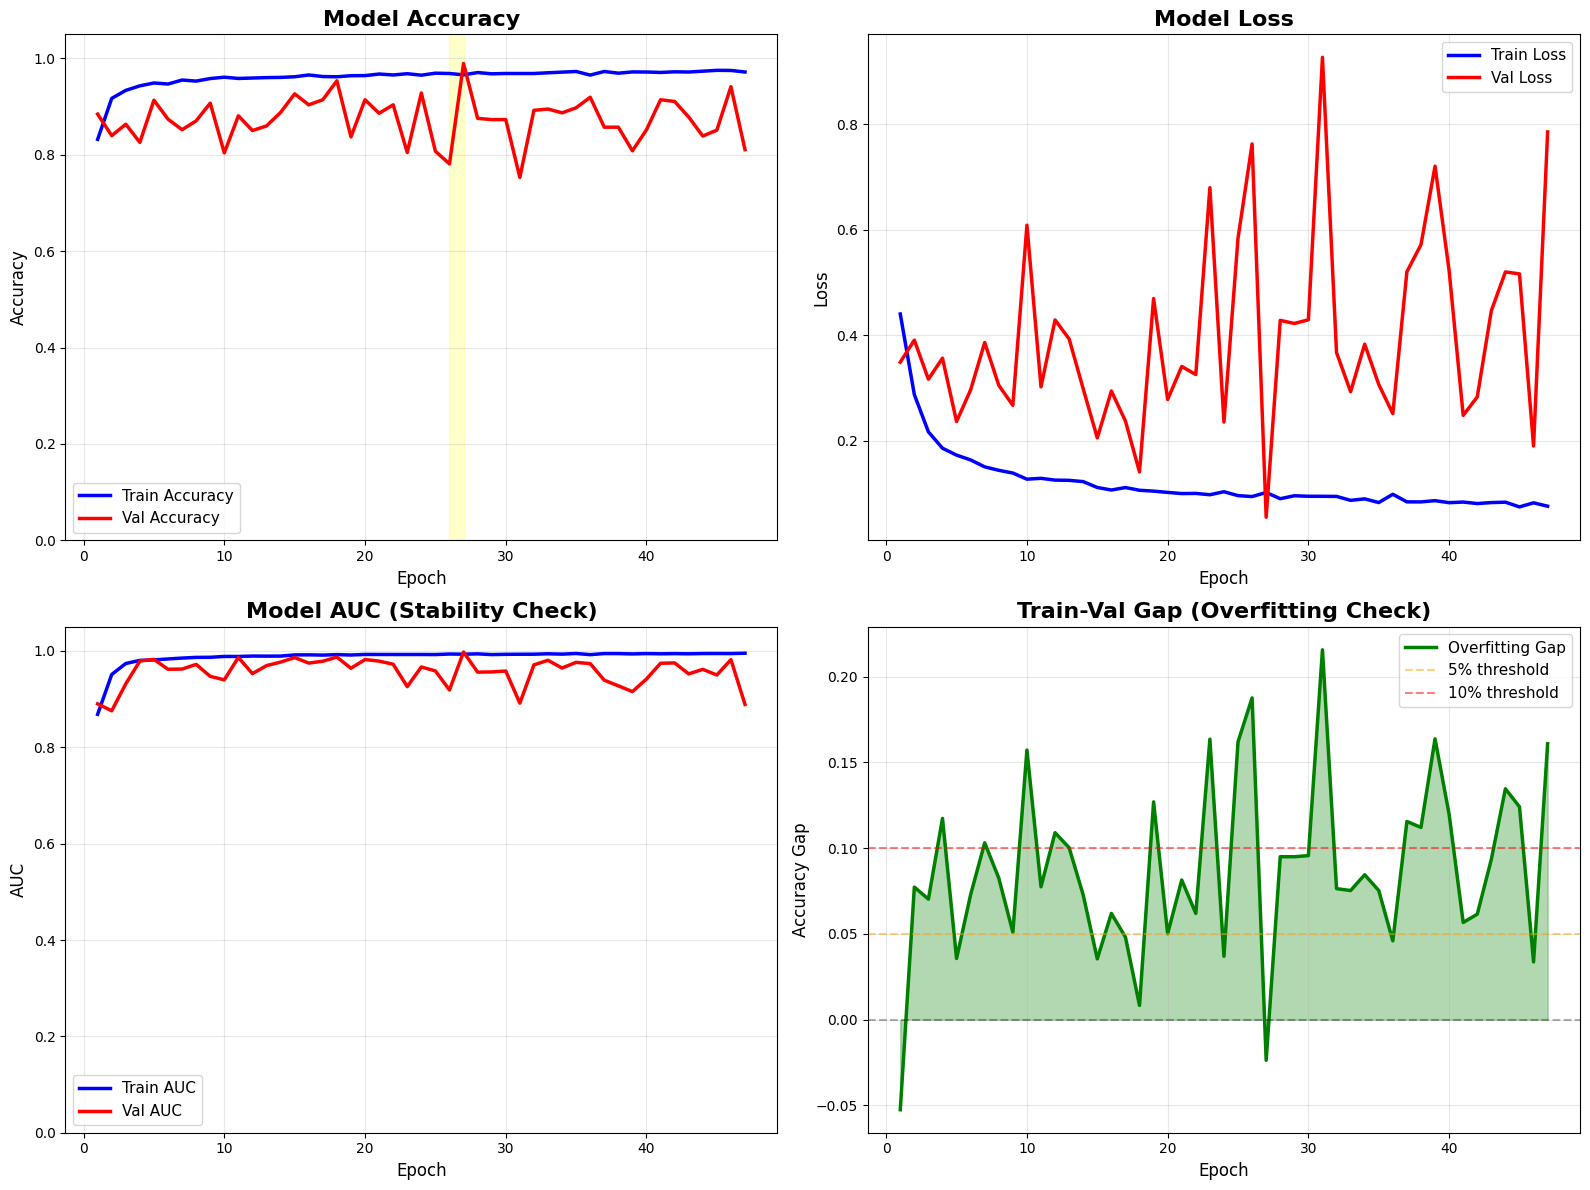


 Validation Accuracy Std Dev: 0.0460
 Very stable training!


In [21]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracy
    axes[0, 0].plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2.5)
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2.5)
    axes[0, 0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1.05])

    # Highlight unstable regions
    val_acc = np.array(history.history['val_accuracy'])
    unstable = np.where(np.abs(np.diff(val_acc)) > 0.15)[0]
    for idx in unstable:
        axes[0, 0].axvspan(idx+1, idx+2, alpha=0.2, color='yellow')

    # Loss
    axes[0, 1].plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2.5)
    axes[0, 1].plot(epochs, history.history['val_loss'], 'r-', label='Val Loss', linewidth=2.5)
    axes[0, 1].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # AUC
    axes[1, 0].plot(epochs, history.history['auc'], 'b-', label='Train AUC', linewidth=2.5)
    axes[1, 0].plot(epochs, history.history['val_auc'], 'r-', label='Val AUC', linewidth=2.5)
    axes[1, 0].set_title('Model AUC (Stability Check)', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC', fontsize=12)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1.05])

    # Gap Analysis
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    gap = train_acc - val_acc

    axes[1, 1].plot(epochs, gap, 'g-', label='Overfitting Gap', linewidth=2.5)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='5% threshold')
    axes[1, 1].axhline(y=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
    axes[1, 1].fill_between(epochs, 0, gap, alpha=0.3, color='green')
    axes[1, 1].set_title('Train-Val Gap (Overfitting Check)', fontsize=16, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy Gap', fontsize=12)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_stable.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Stability metrics
    val_std = np.std(history.history['val_accuracy'])
    print(f"\n Validation Accuracy Std Dev: {val_std:.4f}")
    if val_std < 0.05:
        print(" Very stable training!")
    elif val_std < 0.10:
        print("  Moderate stability")
    else:
        print(" Unstable training - see recommendations below")

plot_training_history(history)

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from google.colab import files   # remove if not using Colab

# Create folder for saving plots
plot_dir = "binary_plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # ---------------------- ACCURACY ----------------------
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', linewidth=2.5)
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5)
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/accuracy.png", dpi=200, bbox_inches='tight')
    plt.close()

    # ---------------------- LOSS ----------------------
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history.history['loss'], label='Train Loss', linewidth=2.5)
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', linewidth=2.5)
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/loss.png", dpi=200, bbox_inches='tight')
    plt.close()

    # ---------------------- AUC ----------------------
    if "auc" in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, history.history['auc'], label='Train AUC', linewidth=2.5)
        plt.plot(epochs, history.history['val_auc'], label='Val AUC', linewidth=2.5)
        plt.title("Model AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{plot_dir}/auc.png", dpi=200, bbox_inches='tight')
        plt.close()

    # ---------------------- GAP ANALYSIS ----------------------
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    gap = train_acc - val_acc

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gap, 'g-', label='Train-Val Gap', linewidth=2.5)
    plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.6, label='5% threshold')
    plt.axhline(y=0.10, color='red', linestyle='--', alpha=0.6, label='10% threshold')
    plt.title("Overfitting Gap Analysis")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Gap")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/gap_analysis.png", dpi=200, bbox_inches='tight')
    plt.close()

    print("\nAll plots saved in the 'plots/' folder!")

# Generate and save all plots
plot_training_history(history)

# ---------------------- ZIP FOLDER ----------------------
zip_path = shutil.make_archive("binary_plots", 'zip', plot_dir)
print("ZIP file created:", zip_path)

# ---------------------- DOWNLOAD (Colab only) ----------------------




All plots saved in the 'plots/' folder!
ZIP file created: /content/binary_plots.zip
